In [12]:
%matplotlib inline
import os 
import theano
from theano import tensor as T
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import SVG
import theano.d3viz as d3v


In [5]:
""" What does the softmax learn? """
def analyze_net(w_o, img_dim):    
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)   

    a = np.array(w_o.get_value())  
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 15))
    for i, ax in enumerate(axes.flat):
        ax.set_title(str(i), fontsize=50)
        im = ax.imshow(a[:,i].reshape(img_dim, img_dim), interpolation='none')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    #plt.pause(0.1)
    
def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)       
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h

def mnist(ntrain=60000, ntest=10000, onehot=True):
    """
    Load and devide MNIST data set into train, test sets
    X is image, and Y is its label.
    The image size is 28*28, and we flatten it to a 784-dim vector
    
    The label is represented in onehot vector. A onehot vector is 
    a vector which is 0 in most dimensions, and 1 in a single 
    dimension. In this case, the nth digit will be represented as 
    a vector which is 1 in the nth dimensions. 
    For example, 0 would be [1,0,0,0,0,0,0,0,0,0,0]. 
    """
    
    data_dir = 'datasets\\mnist'
    
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]
    
    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY

trX, teX, trY, teY = mnist(onehot=True)  #Loading data matrices

In [58]:
def floatX(X):
    """ Conver to correct dtype """
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    """ initalize model parameters """
    return theano.shared(floatX(np.random.randn(*shape) * 0.01), name="w")

def init_bias(n_out):
    """ initialize bias weight as a vector of 0s"""
    return theano.shared(floatX(np.zeros((n_out,))), name="b")

def model(X, w, b):
    """Logistic regresion in matrix format y = softmax(X.w + b)
    This neural net has no hidden layer.
    """
    return T.nnet.softmax(T.dot(X, w) + b)


In [67]:
X = T.fmatrix("X")  # matrix types variables
Y = T.fmatrix("Y")

w = init_weights((784, 10))  # initalize weights matrix
b = init_bias(10) 

In [68]:
py_x = model(X, w, b)  # p(y|x): probability of label given the input
y_pred = T.argmax(py_x, axis=1)  # probality outputs and max predictions

In [69]:
"""
In order to train our model, we need to define what it means for the model 
to be good. Well, actually, in machine learning we typically define what it 
means for a model to be bad, called the cost or loss, and then try to minimize 
how bad it is. But the two are equivalent.

One very common, very nice cost function is "cross-entropy." Surprisingly, 
cross-entropy arises from thinking about information compressing codes in 
information theory but it winds up being an important idea in lots of areas, 
from gambling to machine learning. It's defined:

              H_Y(py_x) = - \sum_i y_i * log(py_x_i)
              
where Y os the true distribution (the one-hot vector we'll input)
py_x is our predicted probability distribution
In some rough sense, the cross-entropy is measuring how inefficient our 
predictions are for describing the truth.   

"""
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))

In [70]:
gradient_w = T.grad(cost=cost, wrt=w)  # Compute gradient for weights w
gradient_b = T.grad(cost=cost, wrt=b)  # Compute gradient for bias b

update = [(w, w - gradient_w * 0.05), 
          (b, b - gradient_b * 0.05)]  # Weight update with gradient descent

# compile train function
train = theano.function(inputs=[X, Y], 
                        outputs=cost, 
                        updates=update, 
                        allow_input_downcast=True)

# compile prediction function
predict = theano.function(inputs=[X], 
                          outputs=y_pred, 
                          allow_input_downcast=True)

In [71]:
# run training with 100 iteration and on mini-batches of 128 examples
for i in range(100):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))
        

0 0.8864
1 0.8999
2 0.9053
3 0.9089
4 0.9114
5 0.9132
6 0.9151
7 0.9157
8 0.9167
9 0.9177
10 0.9179
11 0.9184
12 0.9187
13 0.9188
14 0.9192
15 0.9196
16 0.9195
17 0.92
18 0.9206
19 0.9208
20 0.921
21 0.921
22 0.9213
23 0.9218
24 0.922
25 0.9222
26 0.9225
27 0.9225
28 0.9229
29 0.9228
30 0.9224
31 0.9223
32 0.9222
33 0.9222
34 0.9223
35 0.9223
36 0.9225
37 0.9227
38 0.9226
39 0.9227
40 0.923
41 0.9232
42 0.9231
43 0.9231
44 0.9232
45 0.9232
46 0.9234
47 0.9234
48 0.9234
49 0.9233
50 0.9232
51 0.9233
52 0.9235
53 0.9237
54 0.9236
55 0.9235
56 0.9234
57 0.9235
58 0.9236
59 0.9235
60 0.9235
61 0.9234
62 0.9236
63 0.9235
64 0.9236
65 0.9235
66 0.9235
67 0.9236
68 0.9236
69 0.9236
70 0.9235
71 0.9235
72 0.9234
73 0.9235
74 0.9235
75 0.9237
76 0.9238
77 0.9239
78 0.924
79 0.924
80 0.9241
81 0.9242
82 0.9242
83 0.9242
84 0.9243
85 0.9243
86 0.9243
87 0.9245
88 0.9246
89 0.9247
90 0.9247
91 0.9248
92 0.9249
93 0.9251
94 0.9252
95 0.9251
96 0.9252
97 0.9251
98 0.9253
99 0.9253


Softmax [@A] ''   
 |Elemwise{add,no_inplace} [@B] ''   
   |dot [@C] ''   
   | |X [@D]
   | |w [@E]
   |DimShuffle{x,0} [@F] ''   
     |b [@G]


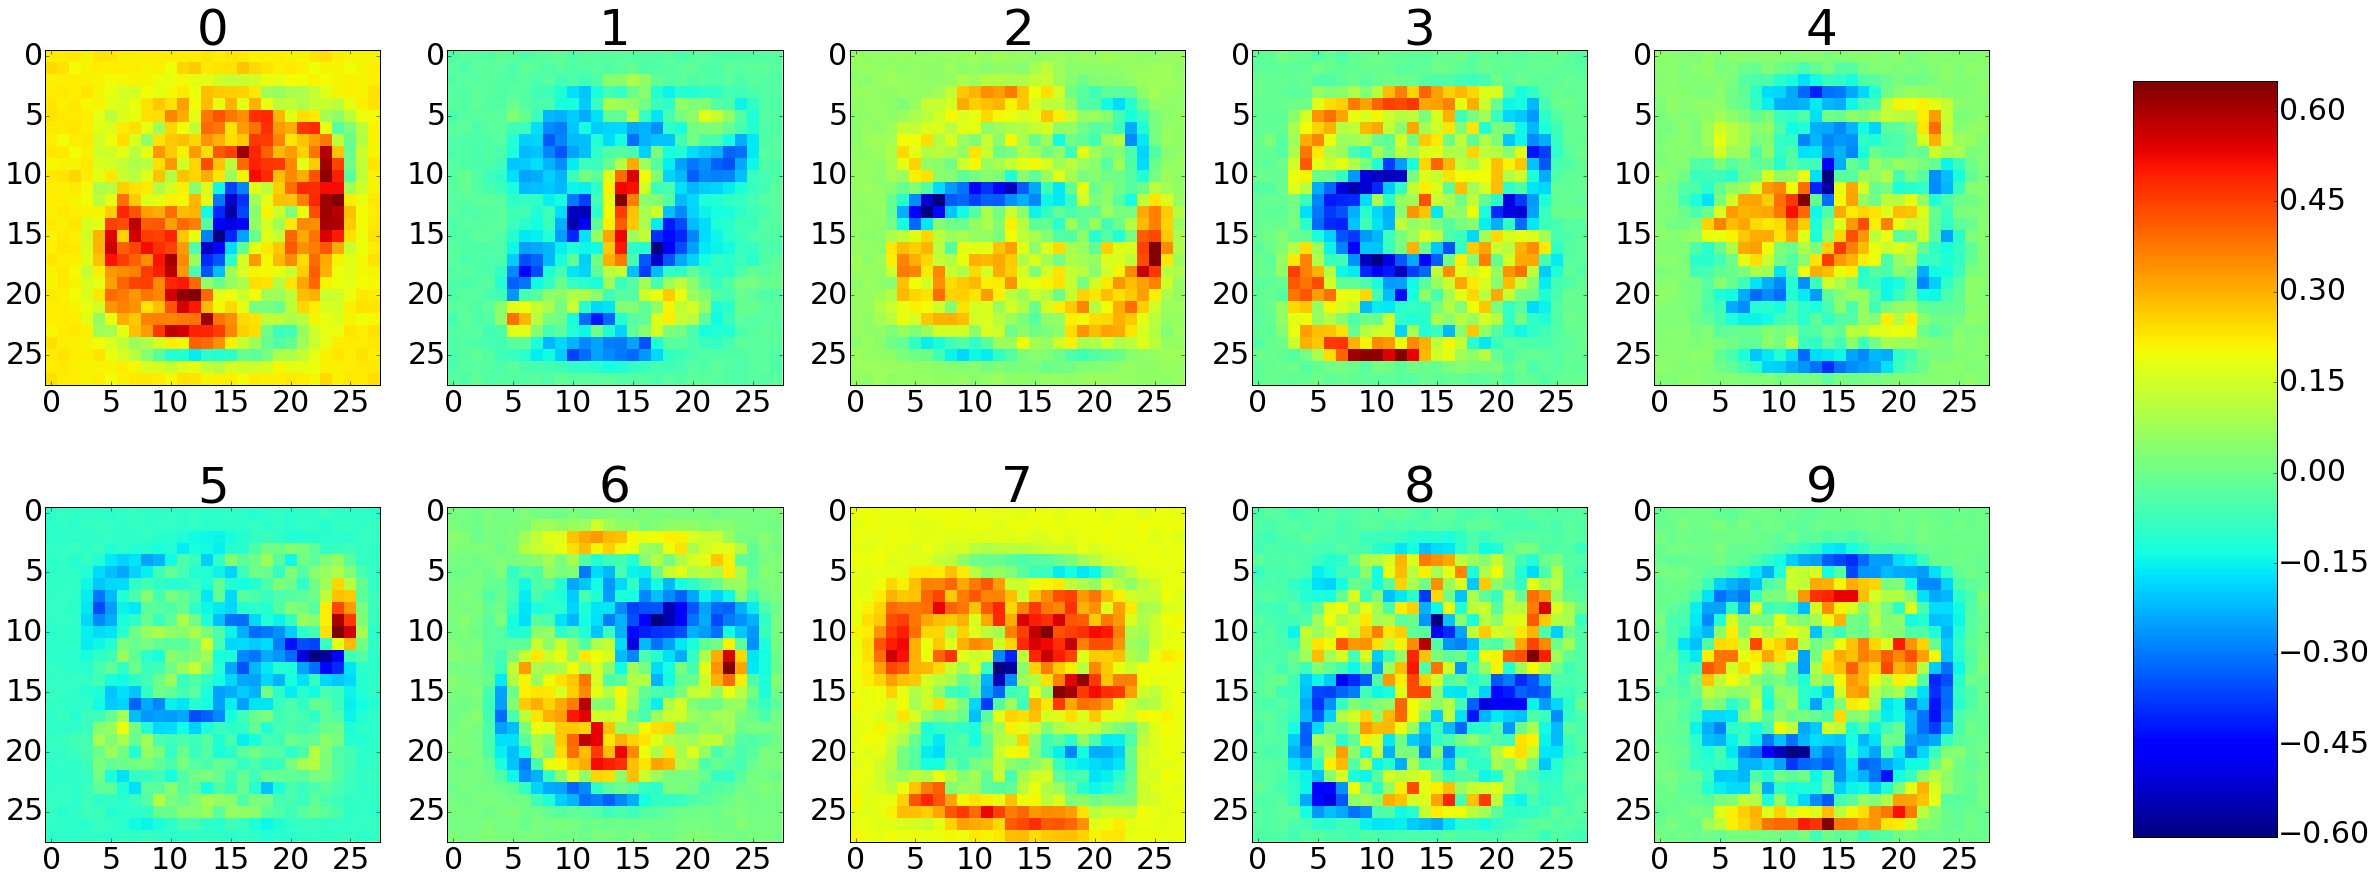

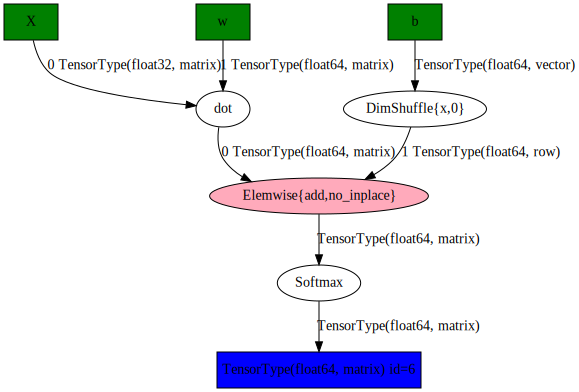

In [72]:
""" What does the softmax learn? """
theano.printing.debugprint(py_x)
analyze_net(w, 28)
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg')) # need to install GraphViz & pydot

In [95]:
""" A feed forward neural network with 1 hidden layer
The NN architecture is 784 -> 635 -> 10
We change model() and use Schotastic Gradient Descent to update weight()
"""

def sgd(cost, params, lr=0.05):
    """generalize to compute gradien descent on all model parameters"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

def model(X, w_h, b_h, w_o, b_o):
    # hidden layer use sigmod as its activation function
    h = T.nnet.sigmoid(T.dot(X, w_h) + b_h)
        
    #output layer still uses softmax
    pyx = T.nnet.softmax(T.dot(h, w_o) + b_o)
    return pyx


In [96]:
w_h = init_weights((784, 625))  # initialize weights for hidden layer
b_h = init_bias(625) 
w_o = init_weights((625, 10))
b_o = init_bias(10) 

py_x = model(X, w_h, b_h, w_o, b_o)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_h, b_h, w_o, b_o]  # the NN has 1 hidden layer and 1 output layer with bias vector
updates = sgd(cost, params) # use SGD as it update function

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))          

0 0.7045
1 0.8276
2 0.8684
3 0.8819
4 0.8891
5 0.894
6 0.8982
7 0.9014
8 0.904
9 0.9071
10 0.9093
11 0.9111
12 0.9125
13 0.9138
14 0.9147
15 0.9157
16 0.9165
17 0.9173
18 0.9179
19 0.9184
20 0.9187
21 0.9191
22 0.9194
23 0.9198
24 0.9208
25 0.9213
26 0.9215
27 0.9217
28 0.9219
29 0.9225
30 0.923
31 0.9236
32 0.9239
33 0.9247
34 0.9249
35 0.9254
36 0.9262
37 0.9266
38 0.9267
39 0.9271
40 0.9276
41 0.9287
42 0.9289
43 0.9298
44 0.9305
45 0.9305
46 0.9314
47 0.9325
48 0.9331
49 0.9343


Softmax [@A] ''   
 |Elemwise{add,no_inplace} [@B] ''   
   |dot [@C] ''   
   | |sigmoid [@D] ''   
   | | |Elemwise{add,no_inplace} [@E] ''   
   | |   |dot [@F] ''   
   | |   | |X [@G]
   | |   | |w [@H]
   | |   |DimShuffle{x,0} [@I] ''   
   | |     |b [@J]
   | |w [@K]
   |DimShuffle{x,0} [@L] ''   
     |b [@M]


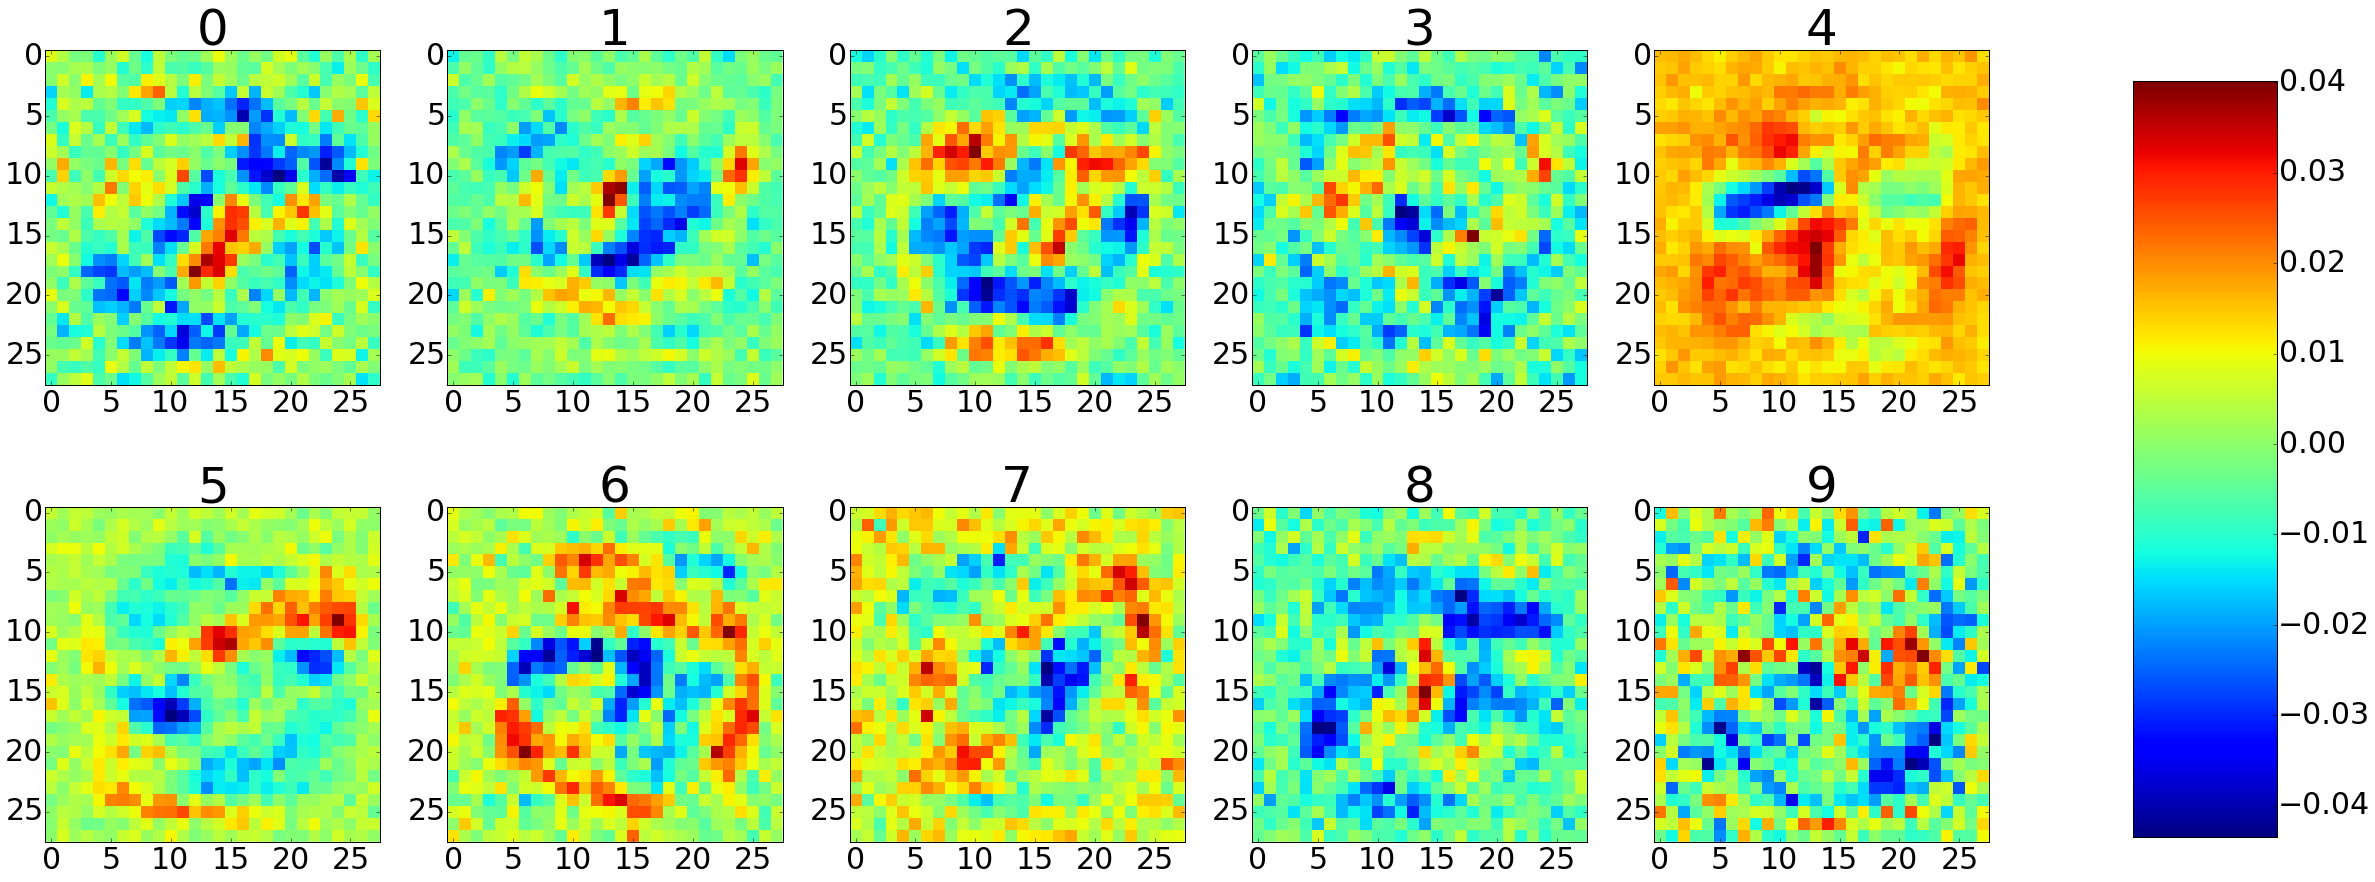

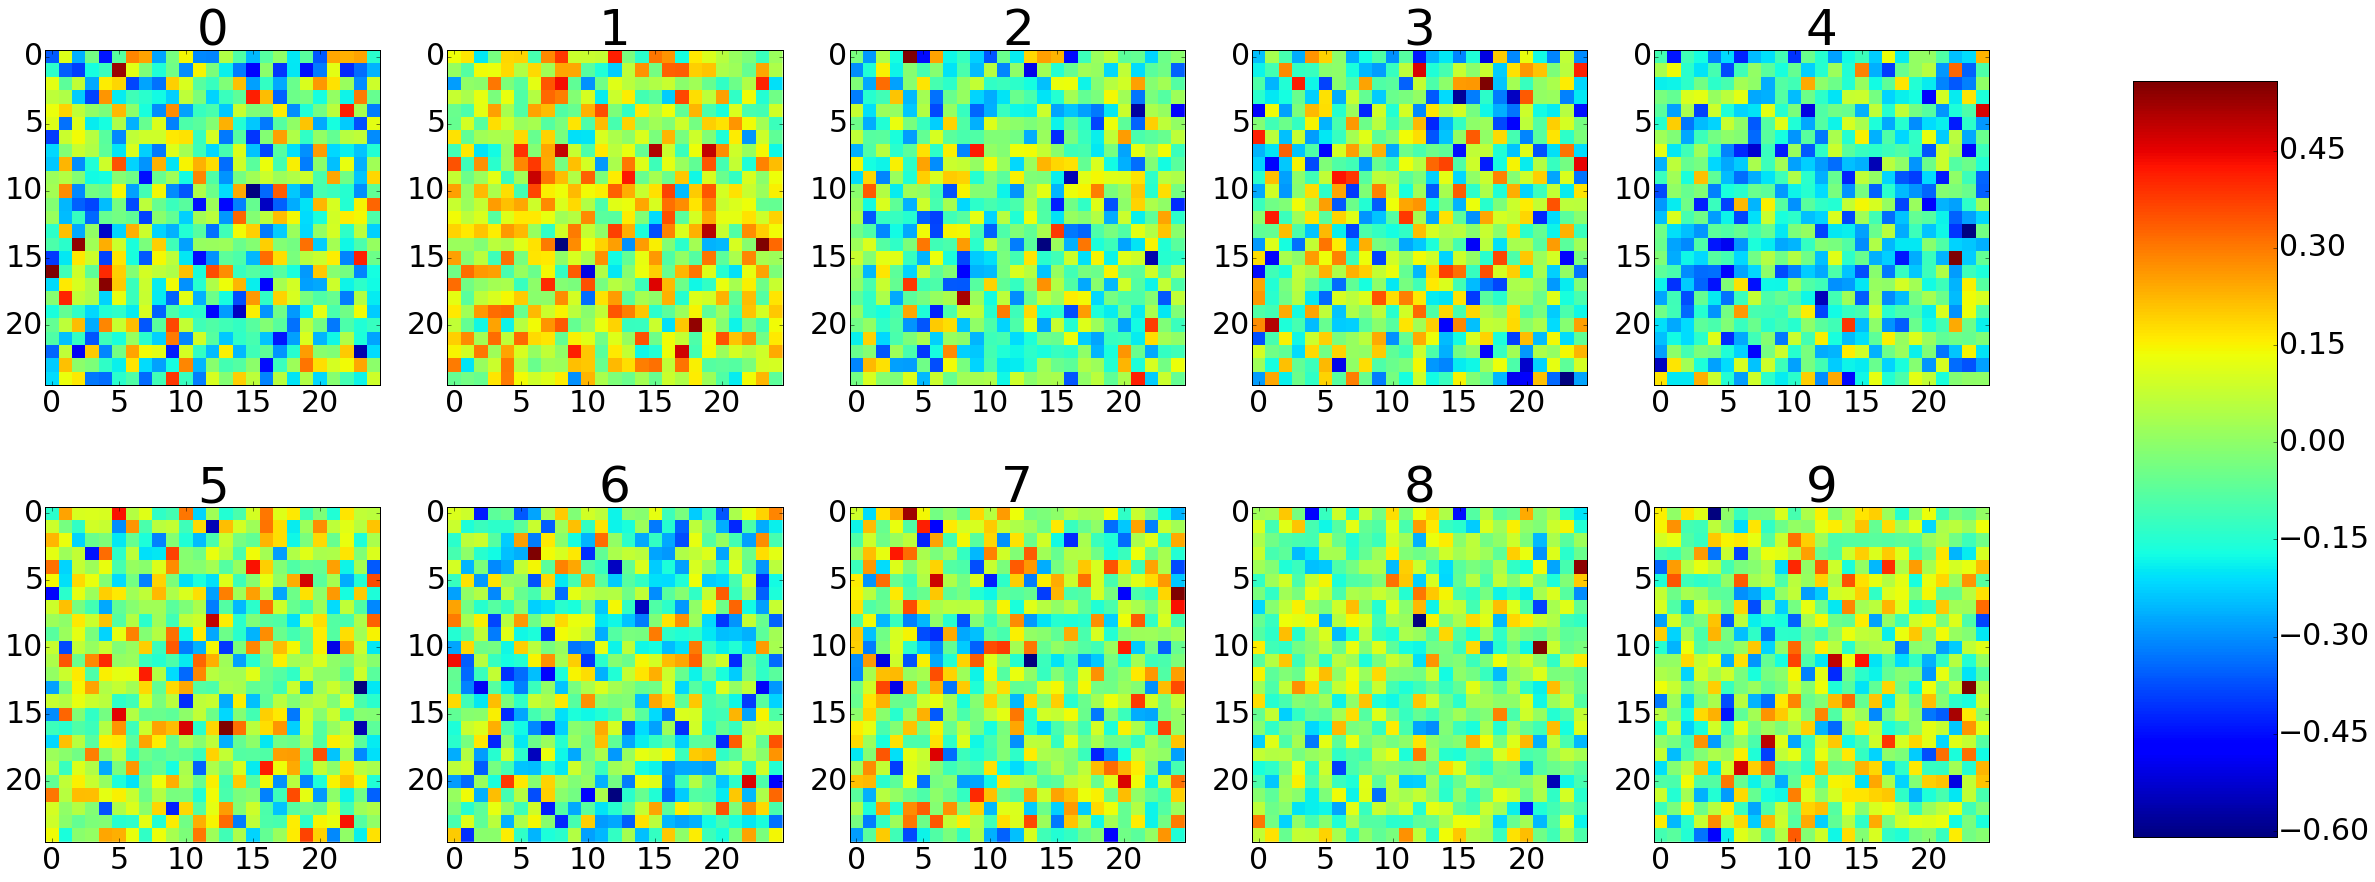

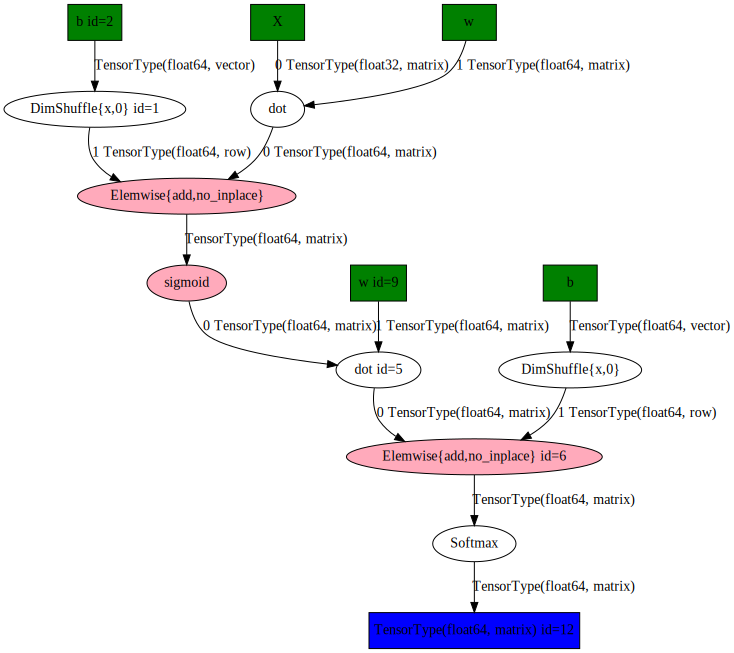

In [99]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_o, 25)
d3v.d3viz(predict, 'test-output/1HiddenLayer.html')
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg'))

In [13]:
"""Modern feed forward net with 2 hiddden layers, fast update using RMSProp, 
ReLU activation function, and dropout to avoi overfitting. The architecture
as follow: 737 -> 625 -> 625 -> 10
"""
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
srng = RandomStreams()

def rectify(X):    
    return T.maximum(X, 0.)

def softmax(X):
    """numerically stable softmax"""
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    """scale the gradient"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        # a running average of the magnitude of the gradient
        
        # initialize acc to be zero in the same shape as p. It 
        # happens once in Python and not in compiled Theano function
        acc = theano.shared(p.get_value() * 0.) 
        
        # Each train execution of acc_new will use the current 
        # value of acc not its initial value.
        acc_new = rho * acc + (1 - rho) * g ** 2
        
        # scale the gradient based on runnning average
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        
        # update weights and accummulator
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):    
    if p > 0:
        # randomly drop values and scale rest
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)  # add some noise into network
    h = rectify(T.dot(X, w_h))

    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [13]:
X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))

0 0.9392
1 0.9648
2 0.9727
3 0.9738
4 0.9767
5 0.9783
6 0.9797
7 0.9794
8 0.9809
9 0.9809
10 0.9814
11 0.9828
12 0.9812
13 0.9827
14 0.9836
15 0.985
16 0.9822
17 0.9831
18 0.9849
19 0.9833
20 0.9844
21 0.9844
22 0.9842
23 0.9839
24 0.9864
25 0.9852
26 0.9851
27 0.9853
28 0.9866
29 0.9856
30 0.9862
31 0.9866
32 0.9853
33 0.9863
34 0.9862
35 0.9857
36 0.9853
37 0.9869
38 0.9858
39 0.9865
40 0.9867
41 0.9869
42 0.9866
43 0.9865
44 0.9863
45 0.9869
46 0.9855
47 0.9868
48 0.987
49 0.9877


Elemwise{true_div,no_inplace} [@A] ''   
 |Elemwise{exp,no_inplace} [@B] ''   
 | |Elemwise{sub,no_inplace} [@C] ''   
 |   |dot [@D] ''   
 |   | |Elemwise{maximum,no_inplace} [@E] ''   
 |   | | |dot [@F] ''   
 |   | | | |Elemwise{maximum,no_inplace} [@G] ''   
 |   | | | | |dot [@H] ''   
 |   | | | | | |<TensorType(float32, matrix)> [@I]
 |   | | | | | |<TensorType(float64, matrix)> [@J]
 |   | | | | |DimShuffle{x,x} [@K] ''   
 |   | | | |   |TensorConstant{0.0} [@L]
 |   | | | |<TensorType(float64, matrix)> [@M]
 |   | | |DimShuffle{x,x} [@N] ''   
 |   | |   |TensorConstant{0.0} [@L]
 |   | |<TensorType(float64, matrix)> [@O]
 |   |DimShuffle{0,x} [@P] ''   
 |     |MaxAndArgmax.0 [@Q] 'max'   
 |       |dot [@D] ''   
 |       |TensorConstant{1} [@R]
 |DimShuffle{0,x} [@S] ''   
   |Sum{axis=[1], acc_dtype=float64} [@T] ''   
     |Elemwise{exp,no_inplace} [@B] ''   


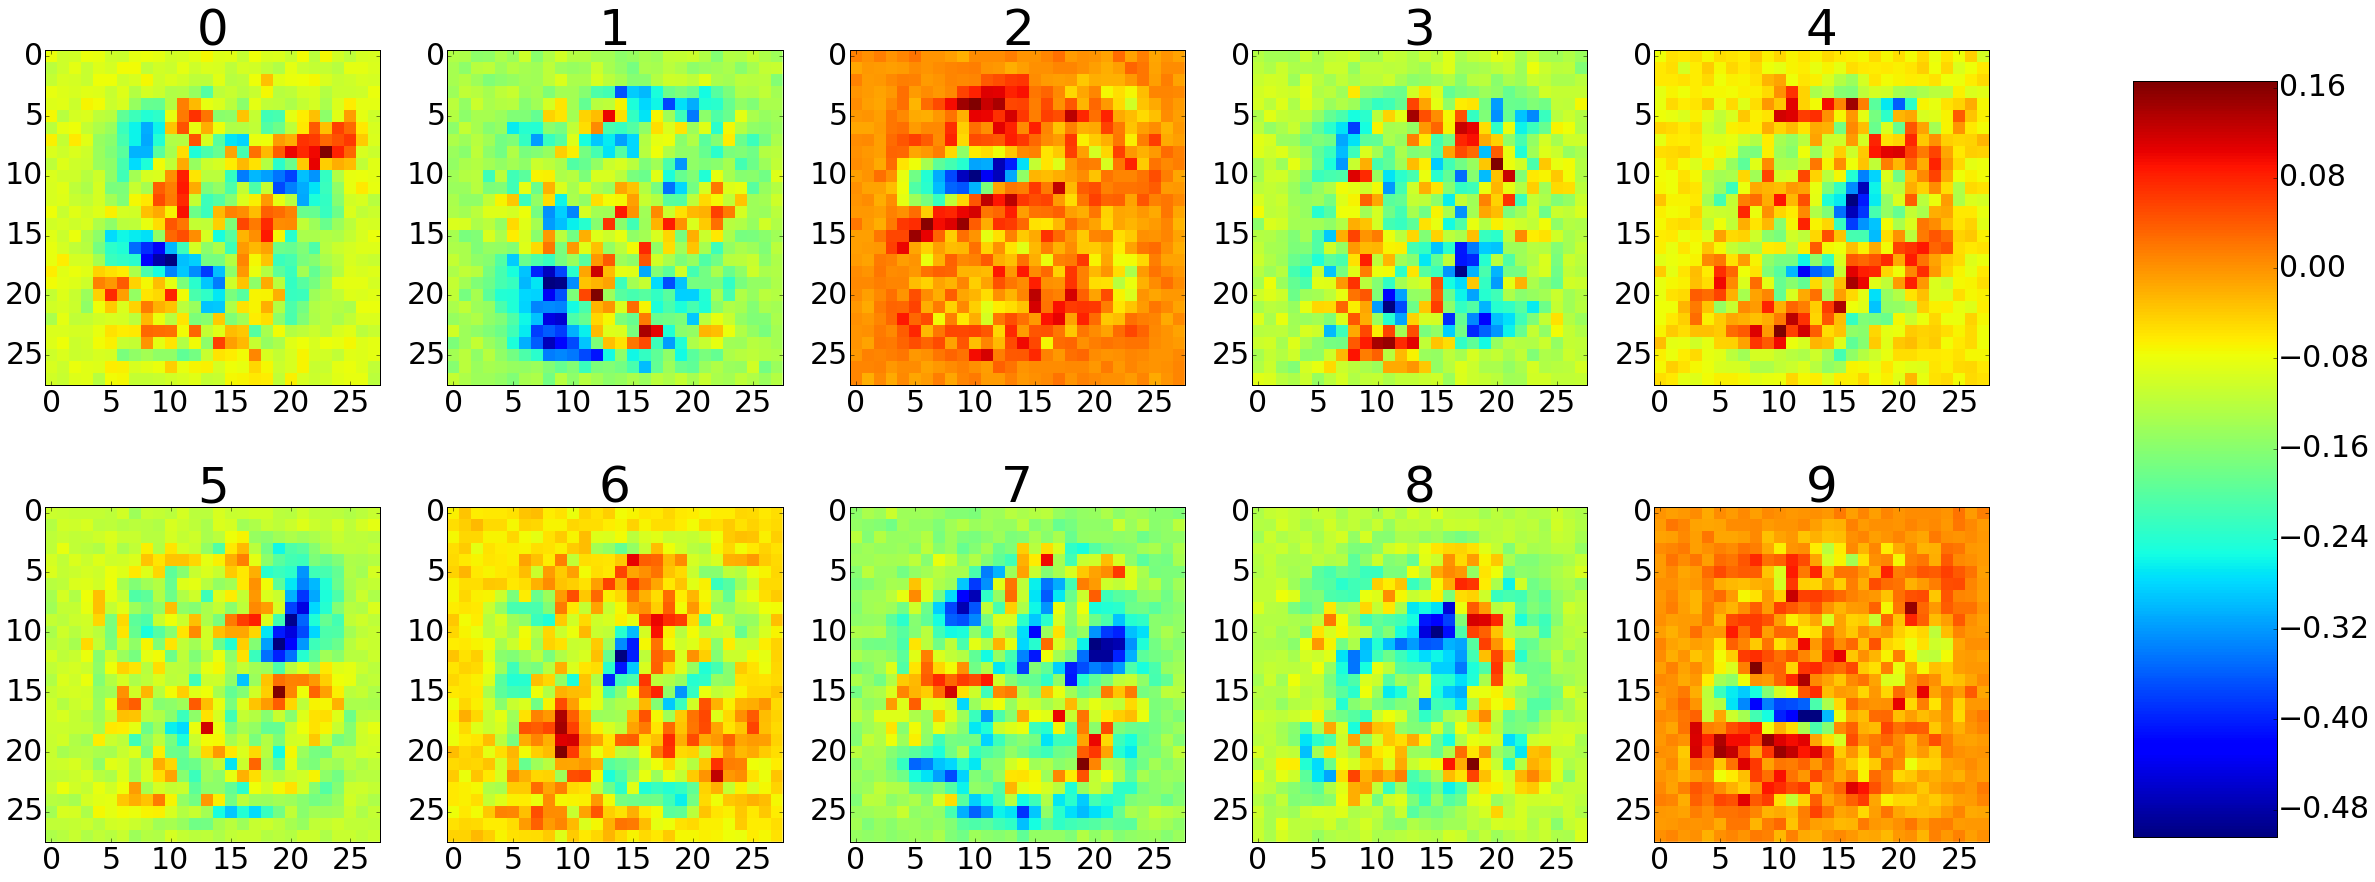

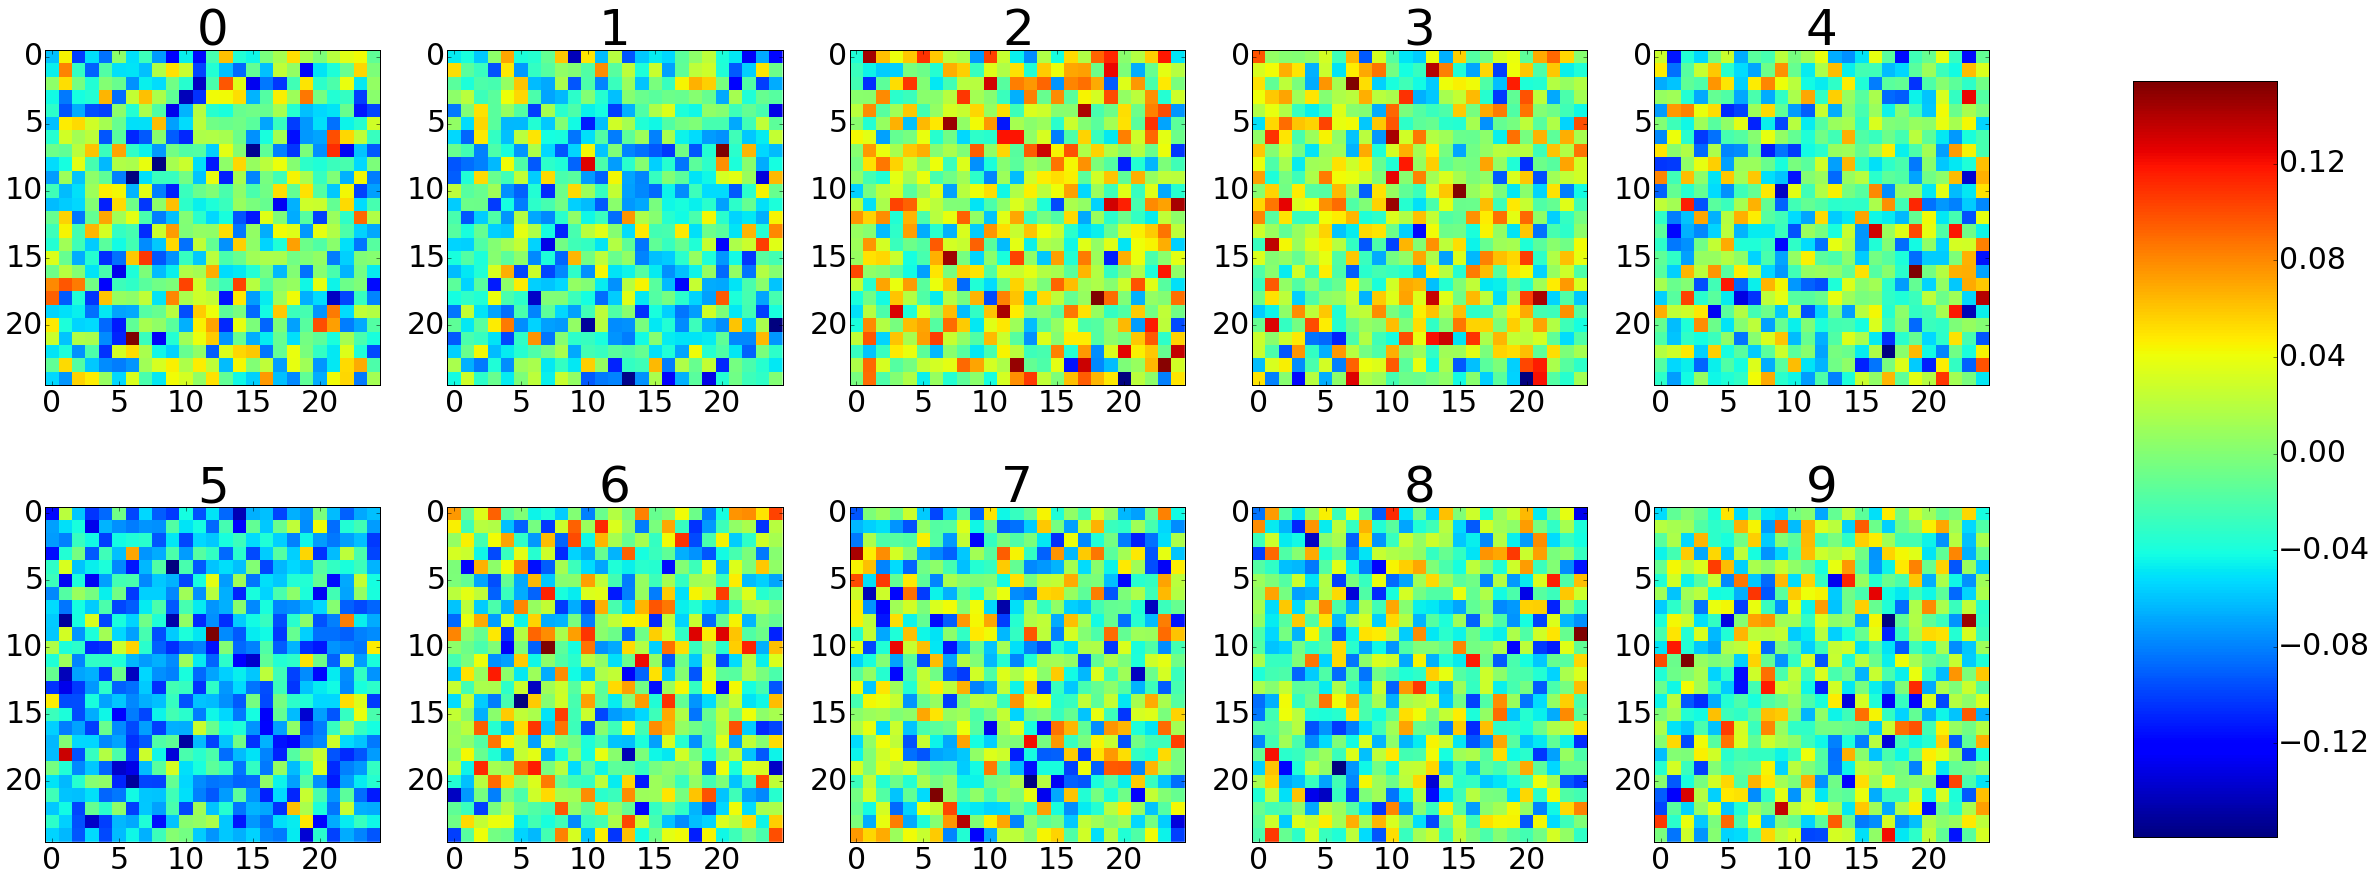

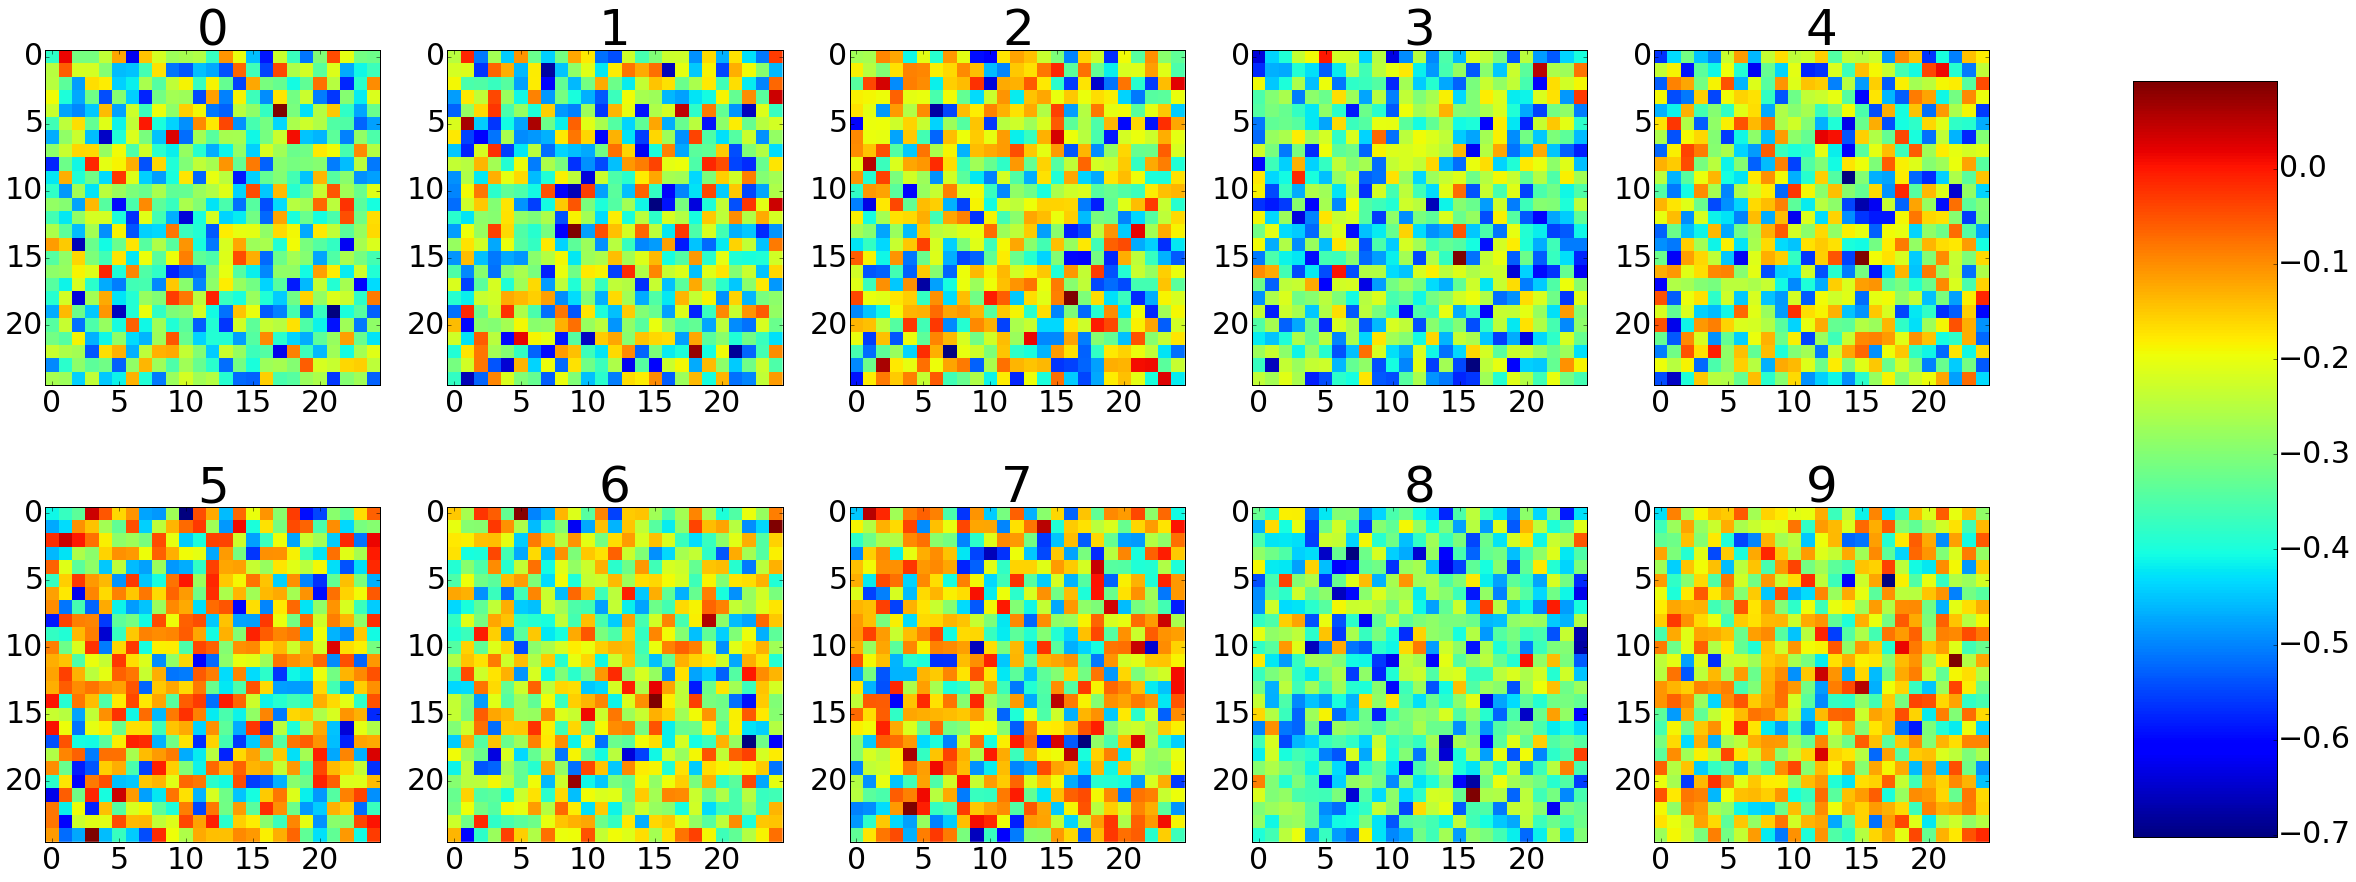

In [31]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_h2, 25)
analyze_net(w_o, 25)
SVG(theano.printing.pydotprint(py_x, return_image=True, format='svg'))

In [14]:
"""Convolutional Neural Network"""
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

def model(X, w, w2, w3, w4, p_drop_conv, p_drop_hidden):
    l1a = rectify(conv2d(X, w, border_mode='full'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = rectify(conv2d(l1, w2))
    l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2, p_drop_conv)

    l3a = rectify(conv2d(l2, w3))
    l3b = max_pool_2d(l3a, (2, 2))
    l3 = T.flatten(l3b, outdim=2)
    l3 = dropout(l3, p_drop_conv)

    l4 = rectify(T.dot(l3, w4))
    l4 = dropout(l4, p_drop_hidden)

    pyx = softmax(T.dot(l4, w_o))
    return l1, l2, l3, l4, pyx

trX, teX, trY, teY = mnist(onehot=True)

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

X = T.dtensor4()
Y = T.fmatrix()

w = init_weights((32, 1, 3, 3))
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((128 * 3 * 3, 625))
w_o = init_weights((625, 10))

noise_l1, noise_l2, noise_l3, noise_l4, noise_py_x = model(X, w, w2, w3, w4, 0.2, 0.5)
l1, l2, l3, l4, py_x = model(X, w, w2, w3, w4, 0., 0.)
y_x = T.argmax(py_x, axis=1)


cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w, w2, w3, w4, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))

0.9283
0.9707
0.9827
0.9871
0.989
0.9898
0.9915
0.9925
0.9916
0.992


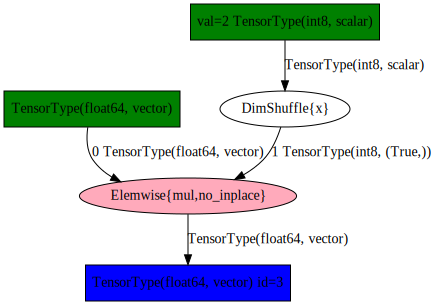

In [17]:
v = theano.tensor.vector()
from IPython.display import SVG
SVG(theano.printing.pydotprint(v*2, return_image=True, format='svg'))